**Steps to do**
1) Read all tif files in the xarray.
2) Then, select the grid cell containing particular location and neighboring 8 grid cells.
3) Keep only good-quality data (QC flag values0, 2, 24, 26, 32, 34, 56, and 58) and set all other values to missing.
4) At each time step, calculate a weighted mean from the nine pixels by weighting them by their standard deviation error (defined as $1/\sigma^2$).
5)  Gap fill the resulting 8-daily time series using a cubic spline function (Forsythe et al., 1977) and set any negative LAI values set to zero.
6)  The gap-filled time series was first smoothed using a cubic smoothing spline.
7)  A climatology (46 time steps) was then calculated from all available years.
8)  An anomaly time series was then created by removing the climatology and smoothed by taking a rolling mean over a window of ±6 time steps to further remove short-term variability.
9)  The climatology was then added to the smoothed time series and the 8-daily time series interpolated to the time resolution of
the flux tower data using the climatological values prior to MODIS commencing in January 2000.

In [21]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [3]:
# This contains all the tif files for the certain location.
file_path = "/home/khanalp/task1/data/MODIS/MODIS_LAI_Export_3"

In [4]:
# Get a list of all .tif files in the directory
tif_files = [os.path.join(file_path, file) for file in os.listdir(file_path) if file.endswith('.tif')]

In [14]:
# The empty weighted_means calculate the spatial weighted mean; steps (1-4) in the above things to do'
weighted_means = []
# List to store the dates
dates = []
# Define the location
#This is the location of the flux sites, later this should be read from the folder.
target_location = (2.284102, 47.322918) 
# The MODIS data comes with the qc flag, these are only the flags which have good quality data. 
# Reference from the Ukkola, PLUMBER2 paper.
qc_allowed = [0, 2, 24, 26, 32, 34, 56, 58]

In [15]:
for file in sorted(tif_files):
    #sorted to sort it by alphabetical order. 

    ## Grabbing date from the folder name
    # Split the file path by '/'
    parts = file.split('/')
    
    # Get the filename part #this part contains date. 
    filename = parts[-1] 
    
    # Extract the date part
    date_str = filename[9:17]  # Adjusted to match the date format in the example
    
    # Convert date string to np.datetime64 format
    date = np.datetime64(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}")
    
    # Append the date to the list
    dates.append(date)
    ## Grabbing date from the folder name

    # open as xarray
    da = xr.open_dataarray(file)

    # Getting the nearest surrounding eight grid cells from the tif files. 

    # Calculate the distances to all points
    distances = np.sqrt((da.x - target_location[0])**2 + (da.y - target_location[1])**2).values.transpose()
    nearest_idx = np.unravel_index(np.argmin(distances), distances.shape)
    
    # Define the window size (assuming 3x3 grid around the nearest cell)
    window_size = 1

    # Extract the subset of the data array centered around the nearest cell
    subset_da = da.isel(
        x=slice(nearest_idx[1] - window_size, nearest_idx[1] + window_size + 1),
        y=slice(nearest_idx[0] - window_size, nearest_idx[0] + window_size + 1)
    )

    # THe LAI value should be scaled by 0.1, refer to the MODIS data user guide. 
    
    LAI = subset_da.sel(band=1).values*0.1
    qc = subset_da.sel(band=2).values
    std = subset_da.sel(band=3).values*0.1

    # Create mask allowing only qc that are present in the list qc_allowed. 
    qc_mask = np.isin(qc, qc_allowed)


    #Also mask out where sd really low (likely cloud effects)
    # Define the threshold value for replacing values with NaN 
    threshold = 0.1
    # Check if each item in the std array is equal to the threshold
    std_mask = std >= threshold
    # Combined mask
    mask = qc_mask*std_mask
    
    if np.sum(mask) > 0:
        #if no data available after masking, replacing by NA else calculating the weighted mean. 
        
        #Weight grid cell estimates by their standard deviation
          #Following Martin's method (https://github.com/mdekauwe/get_MODIS_LAI_australia/blob/master/build_modis_climatology.py),
          #but normalising by sum of standard deviations
        
        # Replace values not in qc_allowed with NA
        qc_processed = np.where(mask, qc, np.nan)
        # Replace values equal to the threshold with NaN
        std_processed = np.where(mask, std, np.nan)
        lai_processed = np.where(mask,LAI,np.nan)

        #weights are from the standard error. 
        weights = 1 / (std_processed**2)
        real_weight= weights/np.nansum(weights)
        weighted_mean = np.nansum(lai_processed * real_weight) / np.nansum(real_weight)
        weighted_means.append(weighted_mean)
    else:
        weighted_means.append(np.nan)


In [16]:
#Changing to numpy array
dates = np.array(dates)
len(weighted_means)

957

NameError: name 'gap_free_lai' is not defined

In [18]:
# Create a DataFrame and changing date to datetime objects
df = pd.DataFrame({'Date': dates, 'Weighted_Mean': weighted_means})
df['Date'] = pd.to_datetime(df['Date'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


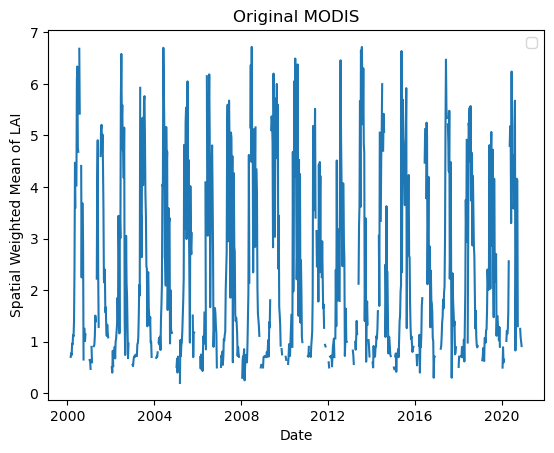

In [25]:
# Plot interpolated values
plt.plot(df['Date'], df['Weighted_Mean'])
plt.xlabel('Date')
plt.ylabel('Spatial Weighted Mean of LAI')
plt.title('Original MODIS')
plt.legend()
plt.show()

**There are several data gaps and it needs to be filled now.**

In [32]:
## Here I will fill all the gaps in the 8-day time series using cubic spline function.

# Create a copy of the original DataFrame
df_filled = df.copy()

# Convert 'Date' column to numeric representation (e.g., days since the first date)
df_filled['Date_numeric'] = (df_filled['Date'] - df_filled['Date'].min()).dt.days
    #(df_filled['Date'] - df_filled['Date'].min()) this calculates the difference of the date from the min date. 
    # and .dt.days gets it in the number of days. 

# Create a mask for NaN values in 'Weighted_Mean'
mask = df_filled['Weighted_Mean'].isna()

# Interpolate NaN values using cubic spline
cs = CubicSpline(df_filled.loc[~mask, 'Date_numeric'], df_filled.loc[~mask, 'Weighted_Mean'])

interpolated_values = cs(df_filled.loc[mask, 'Date_numeric'])

# Fill NaN values with interpolated values only where they exist
df_filled.loc[mask, 'Weighted_Mean'] = interpolated_values

# Drop the 'Date_numeric' column
df_filled.drop(columns=['Date_numeric'], inplace=True)

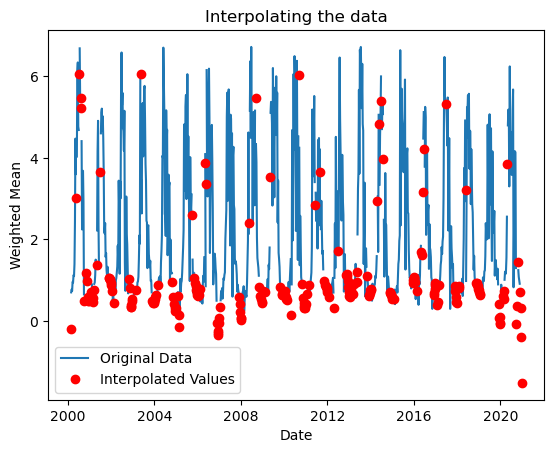

In [33]:
plt.plot(df['Date'], df['Weighted_Mean'], label='Original Data')
# Find indices of NaN values in the original 'Weighted_Mean' column
nan_indices = df['Weighted_Mean'].isna()

# Plot interpolated values
plt.plot(df['Date'][nan_indices], interpolated_values, 'ro', label='Interpolated Values')

plt.xlabel('Date')
plt.ylabel('Weighted Mean')
plt.title('Interpolating the data')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


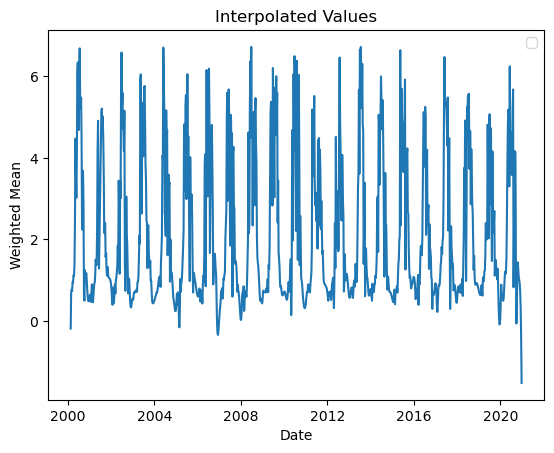

In [34]:
# Plot interpolated values
plt.plot(df_filled['Date'], df_filled['Weighted_Mean'])

plt.xlabel('Date')
plt.ylabel('Weighted Mean')
plt.title('Interpolated Values')
plt.legend()
plt.show()

In [35]:
df_filled_positive = df_filled.copy()
# Subset the DataFrame where 'Weighted_Mean' is negative and replace those values with 0
df_filled_positive.loc[df_filled_positive['Weighted_Mean'] < 0, 'Weighted_Mean'] = 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


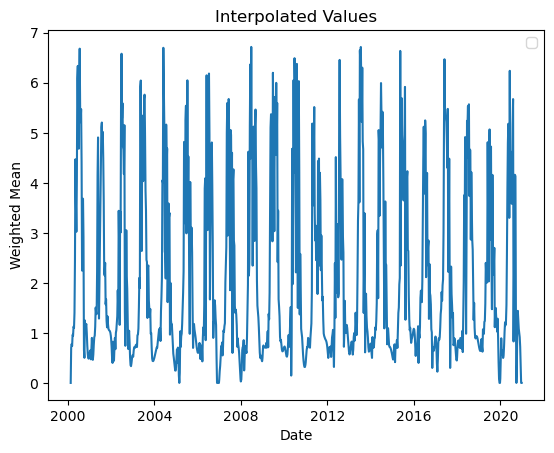

In [37]:
# Plot interpolated values
plt.plot(df_filled_positive['Date'], df_filled_positive['Weighted_Mean'])

plt.xlabel('Date')
plt.ylabel('Weighted Mean')
plt.title('Interpolated Values')
plt.legend()
plt.show()

In [44]:
#I do not see the purpose of smoothing again as done in PLUMBER2.
# Convert 'Date' column to numeric representation (e.g., days since the first date)
df_filled_positive['Date_numeric'] = (df_filled_positive['Date'] - df_filled_positive['Date'].min()).dt.days

# Create a cubic spline interpolation function
cs = CubicSpline(df_filled_positive['Date_numeric'], df_filled_positive['Weighted_Mean'])

# Generate smoothed values by evaluating the interpolation function at the original x-values
smoothed_values = cs(df_filled_positive['Date_numeric'])

# Replace negative values with 0
smoothed_values[smoothed_values < 0] = 0

# Update 'Weighted_Mean' column with smoothed values
df_filled_positive['Smoothed_Weighted_Mean'] = smoothed_values

# Drop the 'Date_numeric' column if you don't need it anymore
df_filled_positive.drop(columns=['Date_numeric'], inplace=True)

df_filled_positive['diff'] = df_filled_positive['Weighted_Mean'] - df_filled_positive['Smoothed_Weighted_Mean']
np.sum(df_filled_positive['diff'])

0.0

In [46]:
#Lets count how many entries per year are in the MODIS data. 

date_counts = df_filled.groupby(df_filled['Date'].dt.year).size()

# Print the counts
print("Number of dates in each year:")
print(date_counts)

Number of dates in each year:
Date
2000    40
2001    44
2002    46
2003    46
2004    46
2005    46
2006    46
2007    46
2008    46
2009    46
2010    46
2011    46
2012    46
2013    46
2014    46
2015    46
2016    45
2017    46
2018    46
2019    46
2020    46
dtype: int64


In [47]:
# Creating an empty dataframe date_df with dates (46 frequency) 8 days apart. 
# Initialize an empty list to store the datetime series
date_series = []

# Loop over each year from 2000 to 2020
for year in range(2002, 2024):
    # Generate the first two dates for the year
    #year_dates = pd.date_range(start=f"{year}-01-01", periods=2, freq='8D')
    
    # Ensure 46 evenly spaced dates for the rest of the year
    year_dates = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='8D')
    
    # Append the datetime series for the current year to the list
    date_series.extend(year_dates)

# Convert the list of datetime series to a pandas DataFrame
date_df = pd.DataFrame(date_series, columns=['Date'])

print(date_df)

          Date
0   2000-01-01
1   2000-01-09
2   2000-01-17
3   2000-01-25
4   2000-02-02
..         ...
961 2020-11-24
962 2020-12-02
963 2020-12-10
964 2020-12-18
965 2020-12-26

[966 rows x 1 columns]


**Now, i have dfs "df_filled_positive" which has columns "Date" and "Smoothed_Weighted_Mean", while another df_date dataframe which has "Date" columns. So, if the the date are same or are differnece of 1 day, i want to copy the data from Smoothed_Weighted_Mean else in the new column in df_date, else i want to keep NA.**

In [48]:
# Initialize the new column  "LAI" in date_df with NaN values
date_df['LAI'] = np.nan

In [49]:
# Iterate over the rows of df_date
for index, row in date_df.iterrows():
    # Check if there is a corresponding date in df_filled_positive that matches or differs by one day
    matching_date = df_filled_positive[(df_filled_positive['Date'] == row['Date']) |
                                        (df_filled_positive['Date'] == row['Date'] + pd.Timedelta(days=1))]
    
    # If matching date(s) found, copy the value of Smoothed_Weighted_Mean to New_Column
    if not matching_date.empty:
        date_df.at[index, 'LAI'] = matching_date.iloc[0]['Smoothed_Weighted_Mean']

In [51]:
# Convert the 'LAI' column to a NumPy array
lai_array = date_df['LAI'].to_numpy().reshape(-1, 46)
lai_array.shape

(21, 46)

In [54]:
#This calculates the climatology, seasonal mean. 
column_means = np.nanmean(lai_array, axis=0)
column_means.shape

(46,)

In [60]:
# Subtract the column mean from each column (subtracting the climatology to get anomalies)
centered_data = lai_array - column_means

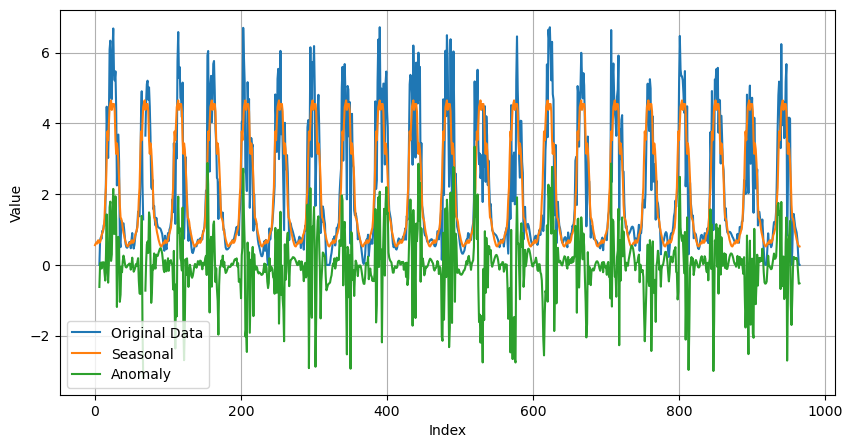

In [63]:
# flattened_data = centered_data.flatten()
# Plot flattened_data
plt.figure(figsize=(10, 5))
plt.plot(lai_array.flatten(), label='Original Data')
plt.plot(np.tile(column_means.flatten(),21), label='Seasonal')
plt.plot(centered_data.flatten(), label='Anomaly')
plt.xlabel('Index')
plt.ylabel('Value')
#plt.title('Anomaly Data')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
# Assuming centered_data contains the centered data after subtracting column means
# Convert the centered data to a pandas DataFrame
df_centered = pd.DataFrame(centered_data.flatten())

# Compute the rolling mean anomaly with a window size of 12 (equivalent to +/- 6 months)
df_smoothed = df_centered.rolling(window=12, min_periods=1).mean()

#print("Rolling mean anomaly:\n", anomaly)
df_smoothed.columns= ['anomaly']

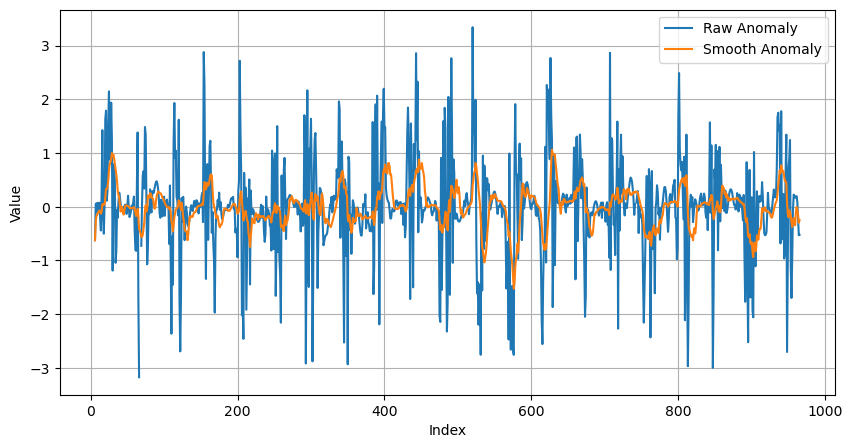

In [66]:
# flattened_data = centered_data.flatten()
# Plot flattened_data
plt.figure(figsize=(10, 5))
plt.plot(centered_data.flatten(), label='Raw Anomaly')
plt.plot(df_smoothed['anomaly'], label='Smooth Anomaly')
plt.xlabel('Index')
plt.ylabel('Value')
#plt.title('Anomaly Data')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Repeat column_means 46 times
repeated_column_means = np.tile(column_means, reps=21)

In [69]:
# Create a new column in df with the repeated column_means
df_smoothed['Seasonal'] = repeated_column_means.flatten()
# Replace NA values in Column_Means with NA where anomaly column has NA
df_smoothed['Seasonal'][df_smoothed['anomaly'].isna()] = np.nan

#To get final processed LAI, we add seasonal back to smooth anomaly.
df_smoothed['LAI_final']= df_smoothed['Seasonal']+df_smoothed['anomaly']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
961    0.714913
962    0.584118
963    0.420965
964    0.231748
965    0.271925
Name: LAI_final, Length: 966, dtype: float64

**Compare raw and smoothed LAI**

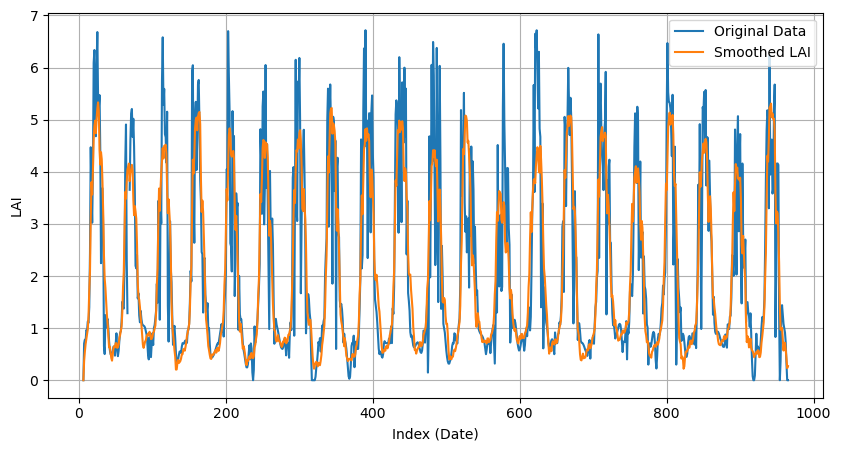

In [72]:
#flattened_data = centered_data.flatten()
# Plot flattened_data
plt.figure(figsize=(10, 5))
plt.plot(lai_array.flatten(), label='Original Data')
#plt.plot(df['anomaly'], label='Anomaly')
#plt.plot(df['Seasonal'], label='Seasonal')
plt.plot(df_smoothed['LAI_final'], label='Smoothed LAI')
plt.xlabel('Index (Date)')
plt.ylabel('LAI')
#plt.title('Anomaly Data')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# Adding date back to df_smoothed
df_smoothed['Date'] = date_series
df_selected = df_smoothed[['Date','LAI_final']]

In [77]:
#Setting Date column as index to do resample to 30 mins, which is the resolution of flux tower.
df_selected.set_index('Date', inplace=True)
df_filled = df_selected.resample('30min').ffill()
#This does not have date beyond 2020-12-26. 

In [80]:
# Reindex to extend the index until '2020-12-31' and forward fill
end_date_extend = pd.to_datetime('2020-12-31')
df_filled = df_filled.reindex(pd.date_range(start=df_filled.index.min(), end=end_date_extend, freq='30min')).ffill()

df_filled.head()

,LAI_final
2000-01-01 00:00:00,NaN
2000-01-01 00:30:00,NaN
2000-01-01 01:00:00,NaN
2000-01-01 01:30:00,NaN
2000-01-01 02:00:00,NaN


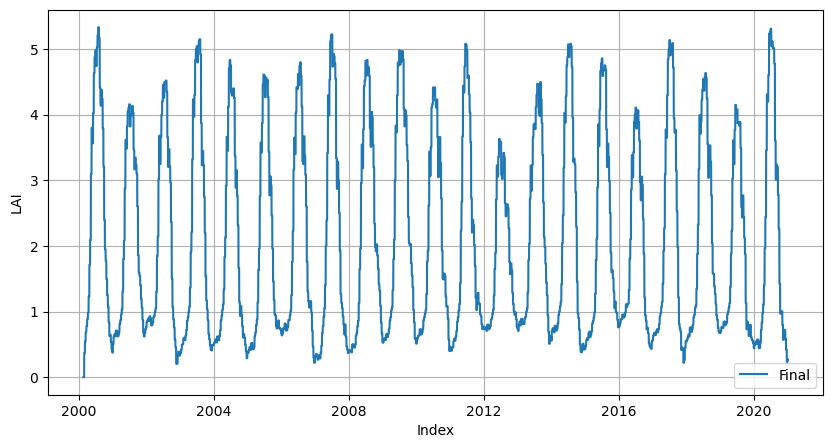

In [79]:
#flattened_data = centered_data.flatten()
# Plot flattened_data
plt.figure(figsize=(10, 5))
#plt.plot(lai_array_reshaped.flatten(), label='Original Data')
#plt.plot(df['anomaly'], label='Anomaly')
#plt.plot(df['Seasonal'], label='Seasonal')
plt.plot(df_filled['LAI_final'], label='Final')
plt.xlabel('Index')
plt.ylabel('LAI')
#plt.title('Anomaly Data')
plt.legend()
plt.grid(True)
plt.show()

**Now, I need to subset for only the time range the flux data are available**

In [82]:
# Take this input from other files later. 
flux_start = "2017-01-01"
flux_end = "2020-12-31"

df_LAI = df_filled['2017-01-01':'2020-12-31']

In [88]:
# Save DataFrame as an Excel file
df_LAI.to_excel('/home/khanalp/task1/output/data_LAI_processed.xlsx', index=True) 

In [92]:
abc = pd.read_excel('/home/khanalp/task1/output/data_LAI_processed.xlsx', index_col = 0)

,LAI_final
2017-01-01 00:00:00,0.630074
2017-01-01 00:30:00,0.630074
2017-01-01 01:00:00,0.630074
2017-01-01 01:30:00,0.630074
2017-01-01 02:00:00,0.630074
...,...
2020-12-30 22:00:00,0.271925
2020-12-30 22:30:00,0.271925
2020-12-30 23:00:00,0.271925
2020-12-30 23:30:00,0.271925


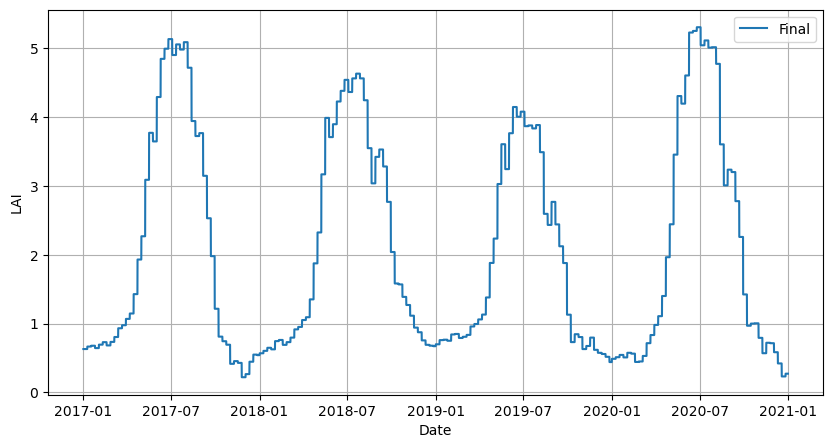

In [85]:
#flattened_data = centered_data.flatten()
# Plot flattened_data
plt.figure(figsize=(10, 5))
#plt.plot(lai_array_reshaped.flatten(), label='Original Data')
#plt.plot(df['anomaly'], label='Anomaly')
#plt.plot(df['Seasonal'], label='Seasonal')
plt.plot(df_LAI['LAI_final'], label='Final')
plt.xlabel('Date')
plt.ylabel('LAI')
#plt.title('Anomaly Data')
plt.legend()
plt.grid(True)
plt.show()